In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import deque

In [2]:
df = pd.read_csv('data.csv',index_col='Date')

# Make some targets for the model to predict with 
- target is the variable 
- seq_len is how many days we will use to predict 
- future_pred is the amount of days we will try to predict into the future. 

    - The classify clause allows you to make a dummy column indicating a buy or a sell signal 
    - when the future price is greater than the current price, this is a buy signal. 
    - when the future price is less than the current price, this is a sell or neutral signal. 

In [3]:
stock = "aapl"
seq_len = 15
future_pred = 5

def classify(current, future):
    if float(future) >float(current):
        return 1
    else:
        return 0

In [4]:
# Shifting the target variable 3 days ahead
df['future'] = df[f"Close_{stock}"].shift(-future_pred)
df['target'] = list(map(classify,df[f"Close_{stock}"],df['future']))

In [5]:
# Check to make sure that the future price is shifted 3 time units upward
#df[[f"Close_{stock}",'future','target']].head(10)

# Need to seperate out of sample data.
- good practice for time series
- without doing this the model will overfit, causing the loss to skyrocket. 
- seperating the last 5% of the data allows us to forward test on the last 5 percent. 

In [6]:
time = sorted(df.index.values)
last5 = time[-int(0.05*len(time))]

In [7]:
val_df = df[df.index>=last5]
df = df[df.index<=last5]

In [8]:
print(f'validation: {len(val_df)}')
print(f'df: {len(df)}')

validation: 62
df: 1198


# Normalizing data. 
- normalize the data
- create the sequences we want to use to predict on
- balance the dataset 

In [9]:
def prep_df(df):
    df = df.drop('future',axis=1)
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change() # gets the percent change 
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    df.dropna(inplace=True)

    seq_data = []
    prev_days = deque(maxlen = seq_len) # appends all the data to the empty list, as it gets new items it deletes the old items 

    for i in df.values:
        prev_days.append([n for n in i[:-1]]) # each of the columns up to the last column (target)
        if len(prev_days) == seq_len:
            seq_data.append([np.array(prev_days), i[-1]])
    np.random.shuffle(seq_data)

    # balance the data 
    buys = []
    sells = []
    for seq, target in seq_data:
        if target== 0:
            sells.append([seq,target])
        elif target ==1:
            buys.append([seq, target])

    np.random.shuffle(buys)
    np.random.shuffle(sells)

    lower = min(len(buys), len(sells))
    buys = buys[:lower]
    sells = sells[:lower]

    seq_data = buys+sells
    np.random.shuffle(seq_data)

    X = []
    y = []
    
    for seq, target in seq_data:
        X.append(seq)
        y.append(target)
    
    return(np.array(X),np.array(y))

In [10]:
train_x, train_y = prep_df(df)
val_x, val_y = prep_df(val_df)

In [11]:
#print(train_x.shape, val_x.dtype)
print(train_y.shape, val_y.dtype)

(878,) float64


In [12]:
print(f'train data: {len(train_x)} validation: {len(val_x)}')
#print(f'Sells: {train_y.count(0)}', f'Buys: {train_y.count(1)}')
#print(f'ValidationSells: {val_y.count(0)}', f'ValidationBuys: {val_y.count(1)}')


train data: 878 validation: 28


# Creating the model 

In [13]:
import datetime as dt 
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

Init Plugin
Init Graph Optimizer
Init Kernel


In [14]:
ep = 10 
batch_size = 64
name = f'{stock}-stock-{seq_len}-seq-{future_pred}=pred-{dt.time()}'


In [15]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss= 'sparse_categorical_crossentropy',optimizer= opt, metrics = ['accuracy'])

# callbacks 
tensorboard = TensorBoard(log_dir=f'logs/{name}')
filepath = "RNN_FINAL-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint('models/{}.h5'.format(filepath, monitor='val_accuracy', save_best_only= True, mode= 'max'))


2021-12-04 14:32:15.260683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-04 14:32:15.260779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-12-04 14:32:15.508774: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-12-04 14:32:15.508784: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-12-04 14:32:15.508800: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [16]:
history = model.fit(
    train_x,train_y, 
    batch_size= batch_size,
    epochs = ep,
    validation_data= (val_x, val_y),
    callbacks=[tensorboard,checkpoint]
    )

2021-12-04 14:32:15.541411: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-04 14:32:15.541591: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-12-04 14:32:15.919341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:32:16.007378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 3/14 [=====>........................] - ETA: 0s - loss: 0.7259 - accuracy: 0.5573

2021-12-04 14:32:16.121778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:32:16.226989: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-12-04 14:32:16.226999: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-12-04 14:32:16.248372: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-04 14:32:16.248942: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-12-04 14:32:16.249830: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/aapl-stock-15-seq-5=pred-00:00:00/train/plugins/profile/2021_12_04_14_32_16
2021-12-04 14:32:16.250334: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/aapl-stock-15-seq-5=pred-00:00:00/train/plugins/profile/2021_12_0

14/14 [==============================] - 1s 46ms/step - loss: 0.7646 - accuracy: 0.5285 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 2/10
 1/14 [=>............................] - ETA: 0s - loss: 0.6865 - accuracy: 0.4844

2021-12-04 14:32:16.691226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:32:16.733102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 29ms/step - loss: 0.7022 - accuracy: 0.5547 - val_loss: 0.6903 - val_accuracy: 0.5357
Epoch 3/10
14/14 [==============================] - 0s 23ms/step - loss: 0.6862 - accuracy: 0.6093 - val_loss: 0.6939 - val_accuracy: 0.5714
Epoch 4/10
14/14 [==============================] - 0s 24ms/step - loss: 0.6519 - accuracy: 0.6264 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 5/10
14/14 [==============================] - 0s 23ms/step - loss: 0.6415 - accuracy: 0.6298 - val_loss: 0.6923 - val_accuracy: 0.4643
Epoch 6/10
14/14 [==============================] - 0s 20ms/step - loss: 0.6392 - accuracy: 0.6116 - val_loss: 0.6947 - val_accuracy: 0.4643
Epoch 7/10
14/14 [==============================] - 0s 21ms/step - loss: 0.6129 - accuracy: 0.6708 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10
14/14 [==============================] - 0s 21ms/step - loss: 0.5990 - accuracy: 0.6697 - val_loss: 0.6949 - val_accuracy: 0.5357
Epoch 9/10
14/14 [======

<AxesSubplot:>

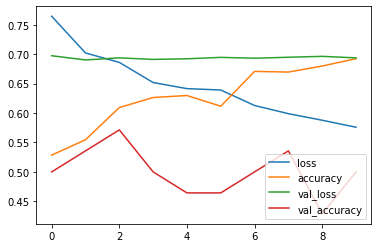

In [17]:
import matplotlib.pyplot as plt 
%matplotlib inline
resdf = pd.DataFrame(history.history)
resdf.plot()

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = np.argmax(model.predict(val_x), axis=1)
print(classification_report(val_y,predictions))

              precision    recall  f1-score   support

         0.0       0.50      0.07      0.12        14
         1.0       0.50      0.93      0.65        14

    accuracy                           0.50        28
   macro avg       0.50      0.50      0.39        28
weighted avg       0.50      0.50      0.39        28



2021-12-04 14:32:20.440750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-04 14:32:20.462533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [19]:
predictions

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0])